# Análisis de Sentimiento en Reseñas de Amazon

## Contexto
El análisis de sentimiento permite clasificar automáticamente reseñas de clientes como positivas o negativas. 
Esto ayuda a las empresas a monitorear la percepción de sus productos, mejorar su atención al cliente 
y tomar decisiones basadas en datos.

## Objetivo del Proyecto
- Preprocesar texto de reseñas reales de Amazon eliminando ruido y palabras irrelevantes.
- Explorar y visualizar el contenido textual para entender su distribución y características.
- Entrenar y evaluar múltiples modelos de Machine Learning y Deep Learning.
- Comparar métricas clave (Accuracy, F1-score y tiempo de entrenamiento).
- Determinar el modelo más eficiente y preciso para clasificación binaria de sentimiento.

## Dataset Utilizado
Este proyecto utiliza el dataset público **Amazon Review Data (2018)**, específicamente la categoría:
**"Industrial and Scientific"**.

- **Fuente:** [Amazon Review Data (2018)](https://nijianmo.github.io/amazon/index.html)
- **Archivo:** `Industrial_and_Scientific_5.json.gz`
- **Características del dataset:**
  - Contiene reseñas de productos con información de texto y puntuaciones de 1 a 5 estrellas.
  - Para este análisis se eliminan las reseñas neutrales (rating = 3) 
    y se clasifican como **Positivo (rating > 3)** o **Negativo (rating < 3)**.

## Herramientas Utilizadas
- **Python 3** como lenguaje principal.
- Librerías de ciencia de datos: `pandas`, `numpy`, `matplotlib`, `sklearn`, `tensorflow`, `transformers`.
- Técnicas: TF-IDF, modelos clásicos de ML, redes neuronales (GRU y Conv1D).

---


In [1]:

# === BLOQUE DE INICIO ===
import os
# Desactivar GPU en Mac (Metal) para evitar bug con GRU/LSTM
# Comentá esta línea si corrés en Google Colab con GPU NVIDIA
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # Debe imprimir []


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, AdamWeightDecay

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cecilialedesma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cecilialedesma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/cecilialedesma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Descargar archivo comprimido en MAC
!curl -k https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz --output '/Industrial_and_Scientific.json.gz'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file /Industrial_and_Scientific.json.gz: Read-only 
  0 10.4M    0  7946    0     0  13849      0  0:13:13 --:--:--  0:13:13 13843
curl: (23) Failure writing output to destination


In [4]:
import gzip
import json

### load the meta data

data = []
with gzip.open('Industrial_and_Scientific.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

77071
{'overall': 5.0, 'verified': True, 'reviewTime': '11 27, 2017', 'reviewerID': 'A1JB7HFWHRYHT7', 'asin': 'B0000223SI', 'style': {'Size:': ' 1-(Pack)'}, 'reviewerName': 'Alex W.', 'reviewText': "This worked really well for what I used it for. So for my purposes it is getting full marks. This is an all around great, durable, and afforable sandpaper.\n\nPros:\n-Grit cuts really fast and evenly. No random deep scratches like I have seen in some cheaper paper\n-Didn't even have a hint of clogging up.\n-The adhesive is just what I needed. No permanent, but wasn't going anywhere.\n\nCons:\n-None", 'summary': "Couldn't have been happier with it's performance", 'unixReviewTime': 1511740800}


In [5]:

# Cargar dataset completo

df = pd.DataFrame(data)
df = df[['reviewText', 'overall']].dropna()
df = df[df['overall'] != 3]
df['sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)
print("Tamaño del dataset:", df.shape)


Tamaño del dataset: (72618, 3)


In [6]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^A-Za-z0-9()!?\'\`\"]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['reviewText'].apply(preprocess_text)


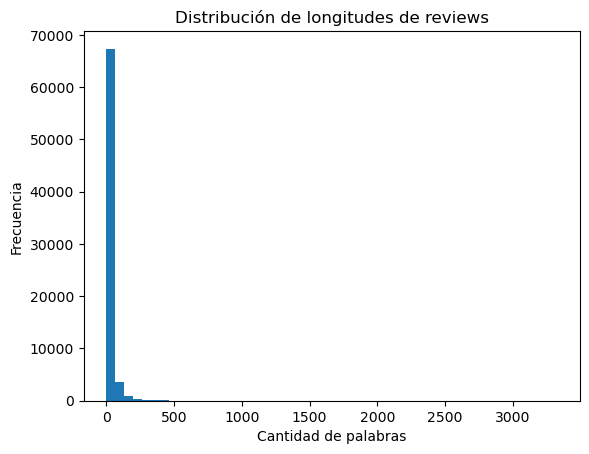

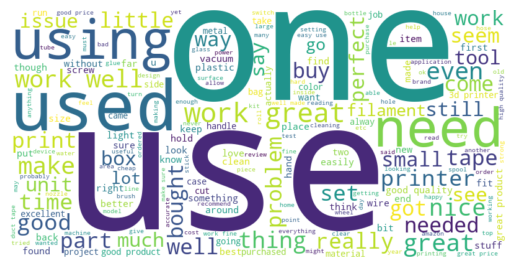

In [7]:

# Longitud de reseñas
df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
plt.hist(df['review_length'], bins=50)
plt.title('Distribución de longitudes de reviews')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.show()

# Nube de palabras
text_all = " ".join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_all)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [8]:

X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Inicializar resultados
results = pd.DataFrame(columns=["Model", "Accuracy", "F1-score", "Training Time (s)"])


In [9]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Linear SVC": LinearSVC()
}

for name, model in models.items():
    start = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - start
    y_pred = model.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = f1_score(y_test, y_pred)
    new_result = pd.DataFrame([{
        "Model": name,
        "Accuracy": report["accuracy"],
        "F1-score": f1,
        "Training Time (s)": train_time
    }])
    results = pd.concat([results, new_result], ignore_index=True)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))


/var/folders/67/7n46534d2gj6_q8jt1h0j2g40000gn/T/ipykernel_20815/1589236575.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


=== Logistic Regression ===
              precision    recall  f1-score   support

    Negative       0.85      0.28      0.42       897
    Positive       0.95      1.00      0.98     13627

    accuracy                           0.95     14524
   macro avg       0.90      0.64      0.70     14524
weighted avg       0.95      0.95      0.94     14524

=== Naive Bayes ===
              precision    recall  f1-score   support

    Negative       0.84      0.07      0.14       897
    Positive       0.94      1.00      0.97     13627

    accuracy                           0.94     14524
   macro avg       0.89      0.54      0.55     14524
weighted avg       0.94      0.94      0.92     14524

=== Random Forest ===
              precision    recall  f1-score   support

    Negative       0.82      0.25      0.39       897
    Positive       0.95      1.00      0.97     13627

    accuracy                           0.95     14524
   macro avg       0.89      0.62      0.68     14524
weig

In [10]:

tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 100
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)


In [11]:

model_gru = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    layers.GRU(64),
    layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

start = time.time()
history = model_gru.fit(X_train_pad, y_train, epochs=5, batch_size=256, validation_split=0.2, verbose=1, callbacks=[early_stop])
gru_time = time.time() - start

loss, acc = model_gru.evaluate(X_test_pad, y_test)
print(f"GRU Accuracy: {acc:.4f}, Training Time: {gru_time:.2f} sec")

# F1-score
y_pred = (model_gru.predict(X_test_pad) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)
new_result = pd.DataFrame([{"Model": "GRU", "Accuracy": acc, "F1-score": f1, "Training Time (s)": gru_time}])
results = pd.concat([results, new_result], ignore_index=True)


2025-08-05 12:43:25.815712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-08-05 12:43:25.815733: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-08-05 12:43:25.815736: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-08-05 12:43:25.815765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-05 12:43:25.815776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2025-08-05 12:43:26.481506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-08-05 12:43:26.614999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/182 [..............................] - ETA: 3s - loss: 0.6796 - accuracy: 0.8154  

2025-08-05 12:43:26.761790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9387

2025-08-05 12:43:30.681522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-08-05 12:43:30.729552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 5s 23ms/step - loss: 0.2295 - accuracy: 0.9387 - val_loss: 0.1574 - val_accuracy: 0.9462
Epoch 2/5
182/182 [==============================] - 4s 20ms/step - loss: 0.1208 - accuracy: 0.9579 - val_loss: 0.1471 - val_accuracy: 0.9533
Epoch 3/5
182/182 [==============================] - 4s 19ms/step - loss: 0.0892 - accuracy: 0.9696 - val_loss: 0.1443 - val_accuracy: 0.9533
Epoch 4/5
182/182 [==============================] - 3s 19ms/step - loss: 0.0677 - accuracy: 0.9768 - val_loss: 0.1565 - val_accuracy: 0.9463
Epoch 5/5
454/454 [==============================] - 3s 5ms/step - loss: 0.1482 - accuracy: 0.9542
GRU Accuracy: 0.9542, Training Time: 18.87 sec
 28/454 [>.............................] - ETA: 1s

2025-08-05 12:43:47.508290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-08-05 12:43:47.543018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


454/454 [==============================] - 2s 3ms/step


In [12]:

model_cnn = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    layers.Conv1D(64, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation='sigmoid')
])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
history = model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=256, validation_split=0.2, verbose=1, callbacks=[early_stop])
cnn_time = time.time() - start

loss, acc = model_cnn.evaluate(X_test_pad, y_test)
print(f"Conv1D Accuracy: {acc:.4f}, Training Time: {cnn_time:.2f} sec")

y_pred = (model_cnn.predict(X_test_pad) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)
new_result = pd.DataFrame([{"Model": "Conv1D", "Accuracy": acc, "F1-score": f1, "Training Time (s)": cnn_time}])
results = pd.concat([results, new_result], ignore_index=True)


Epoch 1/5


2025-08-05 12:43:49.565192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9369

2025-08-05 12:43:52.414675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 3s 16ms/step - loss: 0.2511 - accuracy: 0.9369 - val_loss: 0.1651 - val_accuracy: 0.9419
Epoch 2/5
182/182 [==============================] - 2s 13ms/step - loss: 0.1277 - accuracy: 0.9549 - val_loss: 0.1265 - val_accuracy: 0.9569
Epoch 3/5
182/182 [==============================] - 2s 13ms/step - loss: 0.0898 - accuracy: 0.9686 - val_loss: 0.1262 - val_accuracy: 0.9582
Epoch 4/5
182/182 [==============================] - 2s 11ms/step - loss: 0.0649 - accuracy: 0.9793 - val_loss: 0.1333 - val_accuracy: 0.9571
Epoch 5/5
454/454 [==============================] - 2s 3ms/step - loss: 0.1308 - accuracy: 0.9553
Conv1D Accuracy: 0.9553, Training Time: 12.01 sec
127/454 [=======>......................] - ETA: 0s

2025-08-05 12:44:03.013351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


454/454 [==============================] - 1s 1ms/step


,Model,Accuracy,F1-score,Training Time (s)
0,Linear SVC,0.958758,0.978309,0.158457
1,Conv1D,0.955315,0.976483,12.005020
2,GRU,0.954214,0.975856,18.872161
3,Logistic Regression,0.952424,0.975197,0.098362
4,Random Forest,0.950496,0.974208,23.009656
5,Naive Bayes,0.941889,0.969934,0.004124


Resultados exportados a resultados_modelos.csv


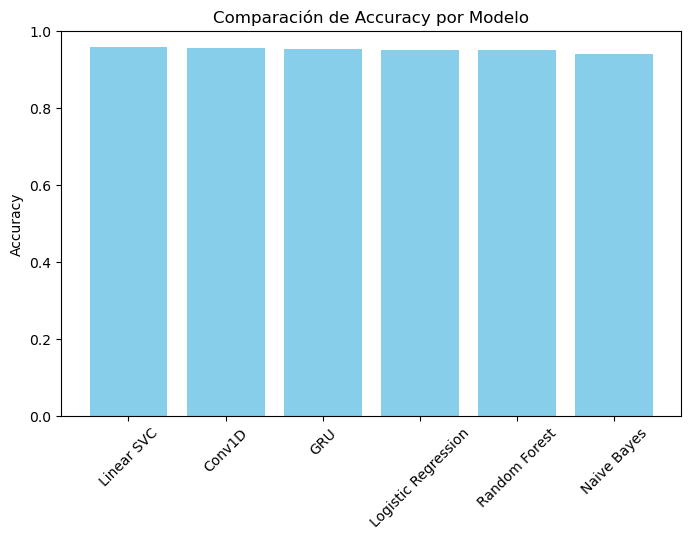

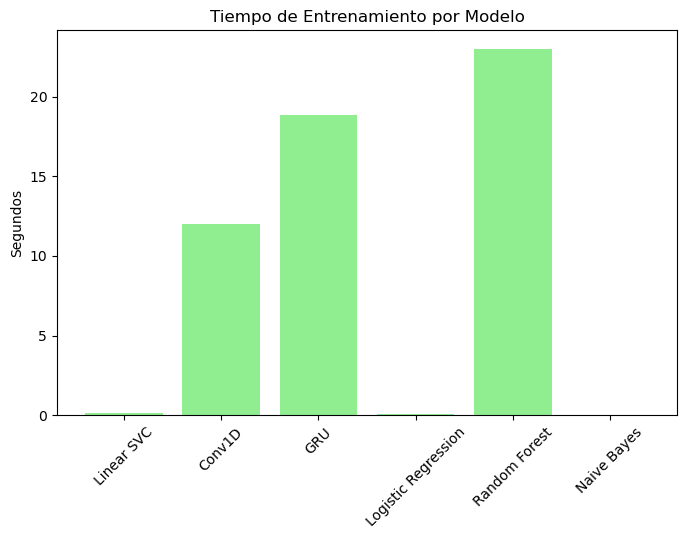

In [13]:

# Comparación de modelos
results_sorted = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
display(results_sorted)

# Exportar resultados
results_sorted.to_csv('resultados_modelos.csv', index=False)
print("Resultados exportados a resultados_modelos.csv")

# Gráficos
plt.figure(figsize=(8,5))
plt.bar(results_sorted["Model"], results_sorted["Accuracy"], color='skyblue')
plt.title("Comparación de Accuracy por Modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(results_sorted["Model"], results_sorted["Training Time (s)"], color='lightgreen')
plt.title("Tiempo de Entrenamiento por Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.show()
